## Regression Analysis
### Predictors
- Spot interest rate
- Price dividend ratio
- Lagged return

### Response
- Stock return

In [18]:
import yfinance as yf
import pandas_datareader.data as web

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import openpyxl

import warnings
warnings.filterwarnings(action='ignore')

In [19]:
start_dt = '2014-11-01'   # extra month to calculate lagged return for 2015-01
ticker = ['SPY']           # S&P 500

In [20]:
# Price data
df = yf.download(ticker,start=start_dt)
df.index = df.index.tz_localize(None)
df = pd.DataFrame(df['Adj Close']).asfreq(freq='M', method='ffill')
df['return'] = df['Adj Close'].pct_change()
df['lagged_return'] = df['return'].shift(1)
df = df[['return', 'lagged_return']]
df.head()

[*********************100%***********************]  1 of 1 completed


,return,lagged_return
Date,,
2014-11-30,NaN,NaN
2014-12-31,-0.002537,NaN
2015-01-31,-0.029629,-0.002537
2015-02-28,0.056204,-0.029629
2015-03-31,-0.015706,0.056204


In [21]:
# spot interest rate
fred = web.DataReader('EFFR','fred',start=start_dt)
fred = fred.shift(1)    # shift to get t-1
fred.head()

,EFFR
DATE,
2014-11-03,NaN
2014-11-04,0.09
2014-11-05,0.10
2014-11-06,0.09
2014-11-07,0.09


In [22]:
# price dividend ratio

market_data = pd.read_excel('ie_data.xls', sheet_name='Data', skiprows=7, skipfooter=1)
market_data['Date'] = pd.to_datetime(market_data['Date'].apply(lambda x: "{:.2f}".format(x)), format='%Y.%m')
market_data.set_index('Date', inplace=True)
market_data['MonthlyDividend'] = market_data['D']/12
market_data['PriceDivRatio'] = market_data['P']/(market_data['D'].rolling(12, min_periods=1).sum()).shift(1)
market_data = market_data[['PriceDivRatio']].asfreq(freq='M', method='ffill')
market_data.sort_index()

,PriceDivRatio
Date,
1871-01-31,NaN
1871-02-28,17.307692
1871-03-31,8.865385
1871-04-30,6.076923
1871-05-31,4.673077
...,...
2022-05-31,5.618900
2022-06-30,5.380716
2022-07-31,5.352889


In [23]:
df = df.join(fred)
df = df.join(market_data)
df['EFFR'] = df['EFFR'].fillna(method='ffill')
df['PriceDivRatio'] = df['PriceDivRatio'].fillna(method='ffill')
df = df.iloc[2:]
df.head()   # 2015-05-31 to 2022-09-30

,return,lagged_return,EFFR,PriceDivRatio
Date,,,,
2015-01-31,-0.029629,-0.002537,0.13,4.505365
2015-02-28,0.056204,-0.029629,0.13,4.579652
2015-03-31,-0.015706,0.056204,0.12,4.529595
2015-04-30,0.009834,-0.015706,0.13,4.516926
2015-05-31,0.012856,0.009834,0.13,4.509930


In [24]:
# print statistics
df.describe()

,return,lagged_return,EFFR,PriceDivRatio
count,93.000000,93.000000,93.000000,93.000000
mean,0.008514,0.009481,0.875806,4.784236
std,0.045277,0.044041,0.864662,0.724727
min,-0.124871,-0.124871,0.040000,3.770706
25%,-0.016743,-0.015706,0.100000,4.336545
50%,0.014113,0.014113,0.410000,4.572031
75%,0.036198,0.036198,1.600000,4.904108
max,0.126984,0.126984,3.080000,6.670873


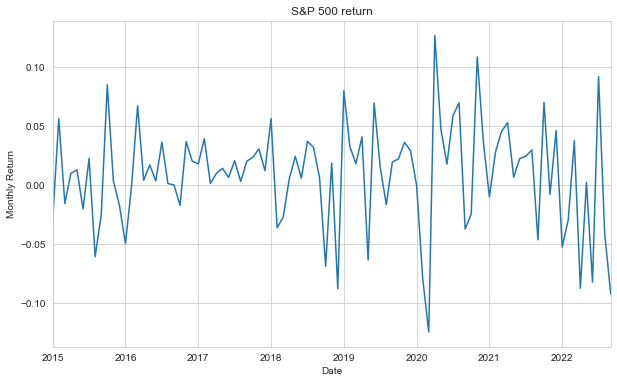

In [25]:
df['return'].plot(figsize=(10, 6))
plt.title('S&P 500 return')
plt.ylabel('Monthly Return')
plt.show()

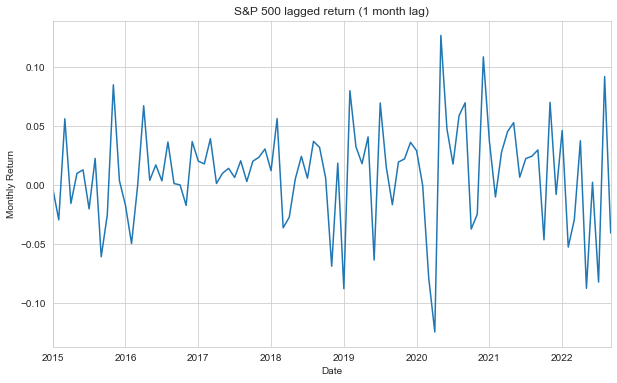

In [26]:
df['lagged_return'].plot(figsize=(10, 6))
plt.title('S&P 500 lagged return (1 month lag)')
plt.ylabel('Monthly Return')
plt.show()

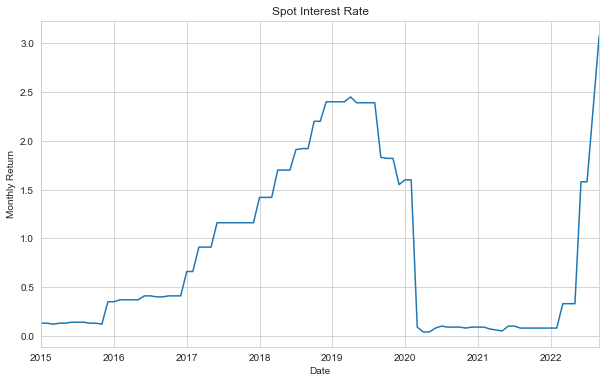

In [27]:
df['EFFR'].plot(figsize=(10, 6))
plt.title('Spot Interest Rate')
plt.ylabel('Monthly Return')
plt.show()

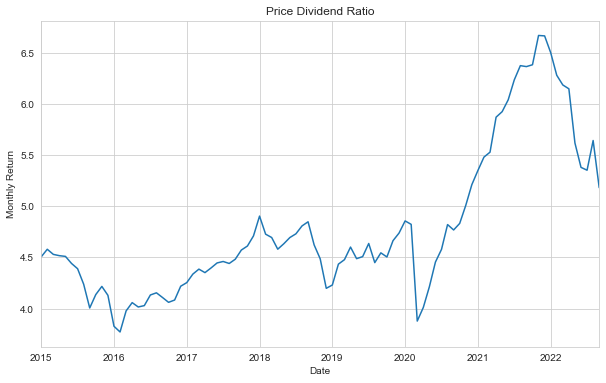

In [28]:
df['PriceDivRatio'].plot(figsize=(10, 6))
plt.title('Price Dividend Ratio')
plt.ylabel('Monthly Return')
plt.show()

In [29]:
# Fitting regression model
y = df['return']
reg = sm.OLS.from_formula\
  (formula="y ~ lagged_return + EFFR + PriceDivRatio",
     data=df).fit()

In [30]:
# Regression Summary
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.138
Date:                Tue, 11 Oct 2022   Prob (F-statistic):              0.338
Time:                        11:23:15   Log-Likelihood:                 158.12
No. Observations:                  93   AIC:                            -308.2
Df Residuals:                      89   BIC:                            -298.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0275      0.033      0.826

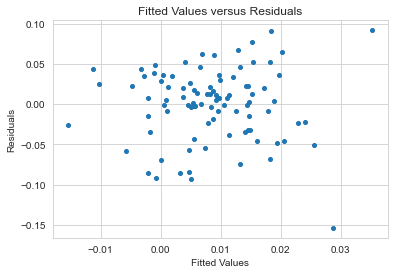

In [31]:
#Fitted values vs Residuals
plt.scatter(reg.fittedvalues,
    reg.resid, s=16)
plt.title("Fitted Values versus Residuals")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.show()

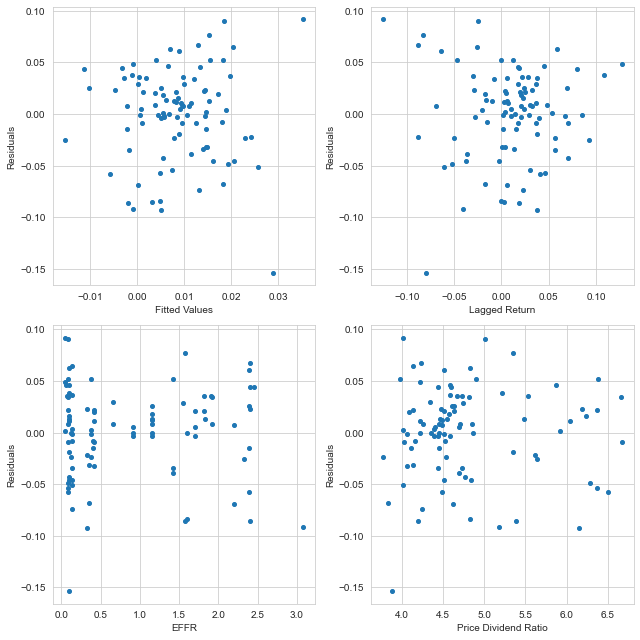

In [32]:
# Residuals vs all variables

from statsmodels.robust.robust_linear_model import reg_tools

# fig = plt.figure(constrained_layout=True)
fig, axs = plt.subplots(2, 2, figsize=[9,9])
# ax1 = fig.add_subplot(221, projection='3d')
# ax2 = fig.add_subplot(222, projection='3d')
# ax3 = fig.add_subplot(223, projection='3d')

axs[0,0].scatter(reg.fittedvalues, reg.resid, s=16)
axs[0,0].set(xlabel="Fitted Values",ylabel="Residuals")

axs[0,1].scatter(df.lagged_return, reg.resid, s=16)
axs[0,1].set(xlabel="Lagged Return",ylabel="Residuals")

axs[1,0].scatter(df.EFFR, reg.resid, s=16)
axs[1,0].set(xlabel="EFFR",ylabel="Residuals")

axs[1,1].scatter(df.PriceDivRatio, reg.resid, s=16)
axs[1,1].set(xlabel="Price Dividend Ratio",ylabel="Residuals")

plt.tight_layout()
plt.show()

In [33]:
df["cookd3"] = reg.get_influence().cooks_distance[0]
df.sort_values("cookd3",ascending=False).head(20)

,return,lagged_return,EFFR,PriceDivRatio,cookd3
Date,,,,,
2020-03-31,-0.124871,-0.079166,0.09,3.877358,0.278825
2020-04-30,0.126984,-0.124871,0.04,4.010343,0.183062
2022-09-30,-0.092446,-0.040802,3.08,5.182476,0.140878
2022-07-31,0.092087,-0.082460,1.58,5.352889,0.067782
2019-01-31,0.080065,-0.088048,2.40,4.229892,0.065609
2022-04-30,-0.087769,0.037590,0.33,6.149213,0.061697
2018-12-31,-0.088048,0.018549,2.40,4.197695,0.048061
2020-05-31,0.047645,0.126984,0.04,4.212962,0.042031
2019-06-30,0.069587,-0.063771,2.39,4.507810,0.038411


In [34]:
#Multicollinearity

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = df.columns
vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
vif_data[vif_data['feature'] != 'return'] # none of the VIF values are very high, so none of the variables show multicollinearity 
# https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

,feature,VIF
1,lagged_return,1.365511
2,EFFR,1.915682
3,PriceDivRatio,2.471362
4,cookd3,1.543624


In [35]:
#Using interaction variables

reg_interaction = sm.OLS.from_formula\
  (formula="y ~ lagged_return + EFFR + PriceDivRatio + lagged_return * EFFR + lagged_return * PriceDivRatio + EFFR * PriceDivRatio",
     data=df).fit()

In [36]:
print(reg_interaction.summary()) #R squared increases a bit but interaction variables are not significant

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.163
Date:                Tue, 11 Oct 2022   Prob (F-statistic):              0.334
Time:                        11:23:18   Log-Likelihood:                 160.00
No. Observations:                  93   AIC:                            -306.0
Df Residuals:                      86   BIC:                            -288.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [37]:
from sklearn.model_selection import train_test_split

x1 = df.iloc[:,1:]
y1 = df.iloc[:,0]

x_train,x_test,y_train,y_test=train_test_split(x1,y1,test_size=0.2,random_state=0)

In [38]:
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

linreg2 = sm.OLS.from_formula\
  (formula="y1 ~ x1",
     data=df).fit()

print(linreg2.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.860
Date:                Tue, 11 Oct 2022   Prob (F-statistic):             0.0280
Time:                        11:23:21   Log-Likelihood:                 162.06
No. Observations:                  93   AIC:                            -314.1
Df Residuals:                      88   BIC:                            -301.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0343      0.032      1.065      0.2

In [39]:
linreg = LinearRegression()
linreg.fit(x_train,y_train)
y_pred=linreg.predict(x_test)
y_pred

array([ 0.0101847 ,  0.01775665,  0.00413995,  0.02818909,  0.04460604,
       -0.00236709,  0.00745493, -0.00046523,  0.01273835,  0.01686321,
        0.01035258,  0.01532344,  0.01840258,  0.02061464, -0.00210886,
        0.00276111,  0.04218559,  0.03341429,  0.00203672])

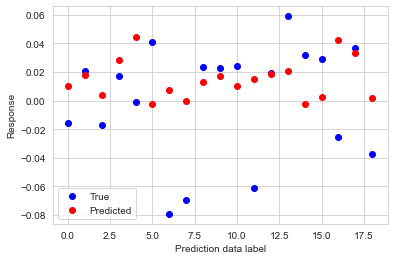

In [40]:
# plt.scatter(y_test,y_pred)
# plt.xlabel('Actual')
# plt.ylabel('Predicted')

plt.scatter(range(len(y_test)), y_test, color='b', label='True')
plt.scatter(range(len(y_pred)), y_pred, color='r', label='Predicted')
plt.ylabel('Response')
plt.xlabel('Prediction data label')
plt.legend()
plt.show()

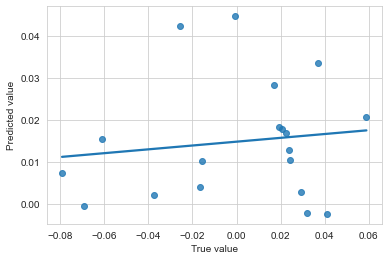

In [41]:
sns.regplot(x=y_test,y=y_pred, ci=None)
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [42]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df.head()

,Actual Value,Predicted Value,Difference
Date,,,
2015-03-31,-0.015706,0.010185,-0.025890
2017-07-31,0.020554,0.017757,0.002797
2019-08-31,-0.016743,0.004140,-0.020883
2016-05-31,0.017011,0.028189,-0.011178
2016-02-29,-0.000826,0.044606,-0.045432


In [43]:
df.head()

,return,lagged_return,EFFR,PriceDivRatio,cookd3
Date,,,,,
2015-01-31,-0.029629,-0.002537,0.13,4.505365,0.006109
2015-02-28,0.056204,-0.029629,0.13,4.579652,0.005021
2015-03-31,-0.015706,0.056204,0.12,4.529595,0.002566
2015-04-30,0.009834,-0.015706,0.13,4.516926,0.000214
2015-05-31,0.012856,0.009834,0.13,4.509930,0.000006


In [44]:
df2 = df

In [45]:
df2.head()

,return,lagged_return,EFFR,PriceDivRatio,cookd3
Date,,,,,
2015-01-31,-0.029629,-0.002537,0.13,4.505365,0.006109
2015-02-28,0.056204,-0.029629,0.13,4.579652,0.005021
2015-03-31,-0.015706,0.056204,0.12,4.529595,0.002566
2015-04-30,0.009834,-0.015706,0.13,4.516926,0.000214
2015-05-31,0.012856,0.009834,0.13,4.509930,0.000006


In [46]:
df2['lagged ** 2'] = df2['lagged_return'] ** 2
df2['lagged ** 3'] = df2['lagged_return'] ** 3
df2['EFFR ** 2'] = df2['EFFR'] ** 2
df2['EFFR ** 3'] = df2['EFFR'] ** 3
df2['PD ** 2'] = df2['PriceDivRatio'] ** 2
df2['PD ** 3'] = df2['PriceDivRatio'] ** 3

In [47]:
Y = df2['return']
X = df2.iloc[:, 1:]

In [48]:
X.head()

,lagged_return,EFFR,PriceDivRatio,cookd3,lagged ** 2,lagged ** 3,EFFR ** 2,EFFR ** 3,PD ** 2,PD ** 3
Date,,,,,,,,,,
2015-01-31,-0.002537,0.13,4.505365,0.006109,0.000006,-1.632291e-08,0.0169,0.002197,20.298311,91.451291
2015-02-28,-0.029629,0.13,4.579652,0.005021,0.000878,-2.601075e-05,0.0169,0.002197,20.973216,96.050036
2015-03-31,0.056204,0.12,4.529595,0.002566,0.003159,1.775463e-04,0.0144,0.001728,20.517230,92.934743
2015-04-30,-0.015706,0.13,4.516926,0.000214,0.000247,-3.874125e-06,0.0169,0.002197,20.402622,92.157135
2015-05-31,0.009834,0.13,4.509930,0.000006,0.000097,9.510277e-07,0.0169,0.002197,20.339467,91.729568


In [49]:
holdlm3 = sm.OLS.from_formula(formula="Y~X", data=df2).fit()


In [51]:
print(holdlm3.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     3.672
Date:                Tue, 11 Oct 2022   Prob (F-statistic):           0.000438
Time:                        11:23:42   Log-Likelihood:                 173.58
No. Observations:                  93   AIC:                            -325.2
Df Residuals:                      82   BIC:                            -297.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.4328      1.550     -1.569      0.1